Below we are importing all of the neccesary packages that we will utilize in order to determine the best neighborhood to live in for a Broke College Student

In [23]:
import pandas as pd
import geopandas as gpd
import numpy
import descartes
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon #Point and Polygon are 2 very specific functions that we utilize to plot points onto maps

%matplotlib inline

# Introduction

Our goal was to determine the best neighborhood for a broke recent college grad to live in, as we will likely be one of them soon enough. This project was really just us planning for our futures, and possibly yours too. You're welcome. 

Our process for choosing the metric started with Mark wanting to get away with parking illegally. We could have looked at the best neighborhood for avoiding tickets, getting away with crime, or alternatively the worst neighborhoods for those things. Instead, we looked a little more broad and realized that free parking saves money, which can also be done by other things, and when we all graduate with plenty of student loans and are looking for our first jobs, we will need that.


# The Metric

In determining the best neighborhood for a broke college grad, we looked at free parking (as mentioned above), cheap housing for rent, and crime rates/safety. There are other things that impact how much it costs to live in an area, such as transportation, distance to activities, groceries, and infinite others (I'm told that's just called "being an adult"), but the three mentioned above cover three major living costs that one has to deal with. 

### Cheap housing for rent

For this metric, I used the Contract Rent dataset from the 2015 Pittsburgh American Community Survey. This dataset inlcudes the number of houses/properties rented in each neighborhood under different price ranges. As most recent graduates are not in a position to buy a house, most will be looking to rent. Paying for housing often takes up the largest portion of ones income, so minimizing the cost of this will be very important to saving money. While this dataset is slightly old, and doesn't account for other costs such as utilities, it can give a good baseline for where each neighborhood sits relative to others in terms of cost of housing. 

I capped "cheap housing" at \\$1000 a month and under. The average Pitt graduate who has a job after graduation (in 2018) had a salary of approximately \\$48,000 a year and could afford \\$1000 a month if they spent 30% of their income on rent, as recommended. Of course, \\$1000 a month is the *limit* of what I am considering cheap, and not necessarily the goal. 

In [24]:
#contract rent dataset
contract_rent_pandas = pd.read_csv("contract-rent.csv", 
                                       index_col="Neighborhood") 
contract_rent_pandas.head() 

,Id,Estimate; Total:,Margin of Error; Total:,Estimate; With cash rent:,Margin of Error; With cash rent:,Estimate; With cash rent: - Less than $100,Margin of Error; With cash rent: - Less than $100,Estimate; With cash rent: - $100 to $149,Margin of Error; With cash rent: - $100 to $149,Estimate; With cash rent: - $150 to $199,...,"Estimate; With cash rent: - $2,000 to $2,499","Margin of Error; With cash rent: - $2,000 to $2,499","Estimate; With cash rent: - $2,500 to $2,999","Margin of Error; With cash rent: - $2,500 to $2,999","Estimate; With cash rent: - $3,000 to $3,499","Margin of Error; With cash rent: - $3,000 to $3,499","Estimate; With cash rent: - $3,500 or more","Margin of Error; With cash rent: - $3,500 or more",Estimate; No cash rent,Margin of Error; No cash rent
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allegheny Center,1,798.0,91.000000,781.0,89.000000,23.0,27.000000,6.0,8.000000,77.0,...,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,17.0,12.000000
Allegheny West,2,77.0,31.000000,77.0,31.000000,0.0,10.000000,0.0,10.000000,0.0,...,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000
Allentown,3,531.0,138.166566,481.0,120.540450,0.0,17.320508,0.0,17.320508,18.0,...,0.0,17.320508,0.0,17.320508,0.0,17.320508,0.0,17.320508,50.0,78.287930
Arlington,4,209.0,70.562029,204.0,69.899928,0.0,17.320508,0.0,17.320508,0.0,...,0.0,17.320508,0.0,17.320508,0.0,17.320508,0.0,17.320508,5.0,15.779734
Arlington Heights,5,144.0,59.000000,140.0,59.000000,0.0,10.000000,6.0,8.000000,23.0,...,0.0,10.000000,0.0,10.000000,0.0,10.000000,0.0,10.000000,4.0,6.000000


### Free Parking


In [25]:
#parking dataset
meters = pd.read_csv("https://data.wprdc.org/datastore/dump/9ed126cc-3c06-496e-bd08-b7b6b14b4109") #Read in the CSV file
meters.head(10) #Display the first 10 items

,id,location,location_type,latitude,longitude,status,zone,all_groups,guid,in_service_utc
0,410168-SCHEDR4402,SCHENLEY DR,On street,40.440574,-79.948103,Removed,410 - Oakland 4,410 - Oakland 4|Z - Inactive/Removed Terminals,EE7C4FB7-038A-461A-A667-002870BA4155,2012-08-27T11:24:43
1,421009-CEDAR-0302,CEDAR AVE,On street,40.451356,-80.001150,Active,421 - NorthSide,NORTHSIDE|421 - NorthSide,5BAC585B-FE5C-4090-ABF8-005D6C670EF1,2013-08-08T11:34:15
2,PBP 412083,FORBES MURRAY LOT,NaN,NaN,NaN,Active,412 - East Liberty,SQ.HILL1,137B2B44-7B23-46D7-A860-009598F38C4C,2021-06-21T18:16:49
3,409242-NDTHRG0106,N DITHRIDGE ST,On street,40.448784,-79.951793,Active,409 - Oakland 3,409 - Oakland 3|OAKLAND3,F4BDCD95-6853-413F-A1C6-009AF3F9D725,2012-09-04T16:08:27
4,PBP412,Virtual Terminal for ParkMobile,Virtual Zone,NaN,NaN,Active,412 - East Liberty,EASTLIB,8FAADCCE-A7BD-4988-85FC-00DCAB30782C,2015-10-23T16:56:58
5,426002-CENTRE1802,CENTRE AVE,On street,40.442621,-79.982096,Active,426 - Hill District,Hill District|426 - Hill District|HILL-DIST,DFCD9083-EE1C-477D-8F82-00F688A1F78C,2017-07-17T11:24:27
6,407118-MEYRAN0203,MEYRAN AVE,On street,40.439856,-79.957367,Active,407 - Oakland 1,OAKLAND1|407 - Oakland 1,E28258E3-6228-4B8C-AD29-012D6AE53A30,2012-08-13T12:25:00
7,402403-BLVDAL0004,BLVD OF ALLIES,On street,40.439707,-80.005472,Active,402 - Downtown 2,402 - Downtown 2|DOWNTOWN2,27D7B43B-71C7-48F2-A124-0193C266B650,2012-11-05T15:37:19
8,415018-ECARSN0701,E CARSON ST,On street,40.428684,-79.991694,Active,415 - SS & SSW,SOUTHSIDE|P10SouthSide|415 - SS & SSW,EB023D05-211C-4C76-9F03-01A548EBC0D0,2012-09-12T19:55:17
9,421054-WESTRN0802,WESTERN AVE,On street,40.452262,-80.014551,Active,421 - NorthSide,NORTHSIDE|421 - NorthSide,B99AF93A-D46B-4F2B-8AB4-01B2097712B6,2013-08-06T11:30:23


### Crime Rates
While crime rates are not a monetary value in and of themselves, they have a monetary impact on one's life. Crime rates can affect insurance rates for you home and belongings, but without it people end up paying even more when their person or belongings suffer damage (an occurrence more likely to happen in an area with higher crime rates). In addition, people will end up spending more money and time to prevent harm to themselves or belongings.

In [26]:
# crime rates dataset
crimes = pd.read_csv("https://data.wprdc.org/datastore/dump/044f2016-1dfd-4ab0-bc1e-065da05fca2e")
crimes.head()

,PK,CCR,HIERARCHY,INCIDENTTIME,INCIDENTLOCATION,CLEAREDFLAG,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTHIERARCHYDESC,OFFENSES,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,2802309,16000001.0,10,2016-01-01T00:00:00,"400 Block North Shore DR Pittsburgh, PA 15212",Y,North Shore,1,HARRASSMENT/THREAT/ATTEMPT/PHY,2702 Aggravated Assault. / 2709(a) Harassment....,2205.0,1.0,6.0,-80.012337,40.446263
1,2803174,16004547.0,11,2016-01-01T00:01:00,"5400 Block Carnegie ST Pittsburgh, PA 15201",N,Upper Lawrenceville,2,THEFT BY DECEPTION,3922 Theft by Deception.,1011.0,7.0,2.0,-79.950295,40.482290
2,2801809,16000367.0,4,2016-01-01T00:10:00,"500 Block Mt Pleasant RD Pittsburgh, PA 15214",N,Northview Heights,1,DISCHARGE OF FIREARM INTO OCC.STRUCTURE,2707.1 Discharge of a Firearm into Occupied St...,2609.0,1.0,1.0,-80.000966,40.478651
3,2802315,16000035.0,10,2016-01-01T00:15:00,"300 Block Wood ST Pittsburgh, PA 15222",Y,Golden Triangle/Civic Arena,2,HARRASSMENT/THREAT/ATTEMPT/PHY,2709(a)(3) Harassment No Legitimate Purpose,201.0,6.0,6.0,-80.001251,40.438918
4,2802312,16000024.0,4,2016-01-01T00:16:00,"500 Block Mt Pleasant RD Pittsburgh, PA 15214",N,Northview Heights,1,PROP MISSILE INTO OCC VEHICLE/OR ROADWAY,2705 Recklessy Endangering Another Person. / 3...,2609.0,1.0,1.0,-80.000966,40.478651


# The Best Neighborhood


### The best neighborhood based on rent price: 

After loading in the dataset, I removed the extra columns (the ones pertaining to margin of error or rent prices over \\$1000 a month). I then graphed each neighborhood to show the distribution of the number of properties across the price ranges in each neighborhood. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4dc6794f0>,
      dtype=object)

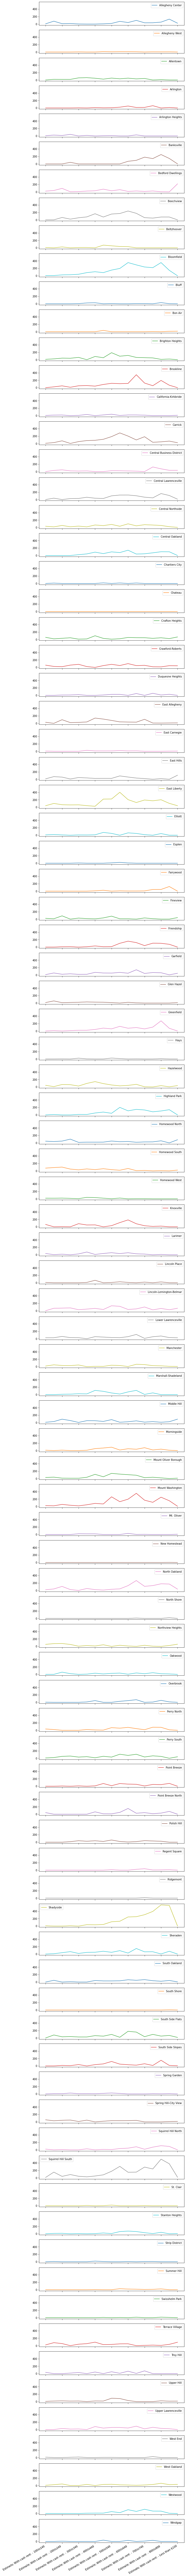

In [27]:
column_list = list(contract_rent_pandas)
columns_to_remove = ["Neighborhood" , "Id" , "Estimate; Total:" , "Margin of Error; Total:" , "Estimate; With cash rent:" , "Margin of Error; With cash rent:" , 
                    "Margin of Error; With cash rent: - Less than $100" , "Margin of Error; With cash rent: - $100 to $149" , "Margin of Error; With cash rent: - $150 to $199" , 
                    "Margin of Error; With cash rent: - $200 to $249" , "Margin of Error; With cash rent: - $250 to $299" , "Margin of Error; With cash rent: - $300 to $349" , 
                    "Margin of Error; With cash rent: - $350 to $399" , "Margin of Error; With cash rent: - $400 to $449" , "Margin of Error; With cash rent: - $450 to $499" , 
                    "Margin of Error; With cash rent: - $500 to $549" , "Margin of Error; With cash rent: - $550 to $599" , "Margin of Error; With cash rent: - $600 to $649" , 
                    "Margin of Error; With cash rent: - $650 to $699" , "Margin of Error; With cash rent: - $700 to $749" , "Margin of Error; With cash rent: - $750 to $799" , 
                    "Margin of Error; With cash rent: - $800 to $899" , "Margin of Error; With cash rent: - $900 to $999" , "Margin of Error; With cash rent: - $1,000 to $1,249" , 
                    "Margin of Error; With cash rent: - $1,250 to $1,499" , "Margin of Error; With cash rent: - $1,500 to $1,999" , "Margin of Error; With cash rent: - $2,000 to $2,499" , 
                    "Margin of Error; With cash rent: - $2,500 to $2,999" , "Margin of Error; With cash rent: - $3,000 to $3,499" , "Margin of Error; With cash rent: - $3,500 or more" , 
                    "Estimate; With cash rent: - $1,000 to $1,249" , "Estimate; With cash rent: - $1,250 to $1,499" , "Estimate; With cash rent: - $1,500 to $1,999" , 
                    "Estimate; With cash rent: - $2,000 to $2,499" , "Estimate; With cash rent: - $2,500 to $2,999" , "Estimate; With cash rent: - $3,000 to $3,499" , 
                    "Estimate; With cash rent: - $3,500 or more" , "Estimate; No cash rent" , "Margin of Error; No cash rent" , "homes under $1000"]

homes_under_1000 = sorted( list(set(column_list) - set(columns_to_remove)))

contract_rent_woMOE = contract_rent_pandas[homes_under_1000]

contract_rent_woMOE.loc["Allegheny Center":"Windgap"].T.plot.line(subplots = True , sharey = True , figsize = (10, 200))

Additionally, I graphed the total number of properties for rent for under \\$1000 each month in a bar graph and on a map of Pittsburgh to visualize where there were more rented properties in total and the relative proximities to each other. 

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 7 Text major ticklabel objects>)

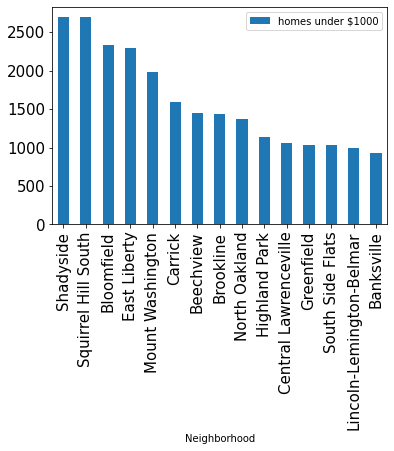

In [28]:
contract_rent_pandas["homes under $1000"] = contract_rent_pandas[homes_under_1000].sum(axis = 1)

contract_rent_pandas["homes under $1000"].sort_values(ascending = False).head(15).plot.bar()
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

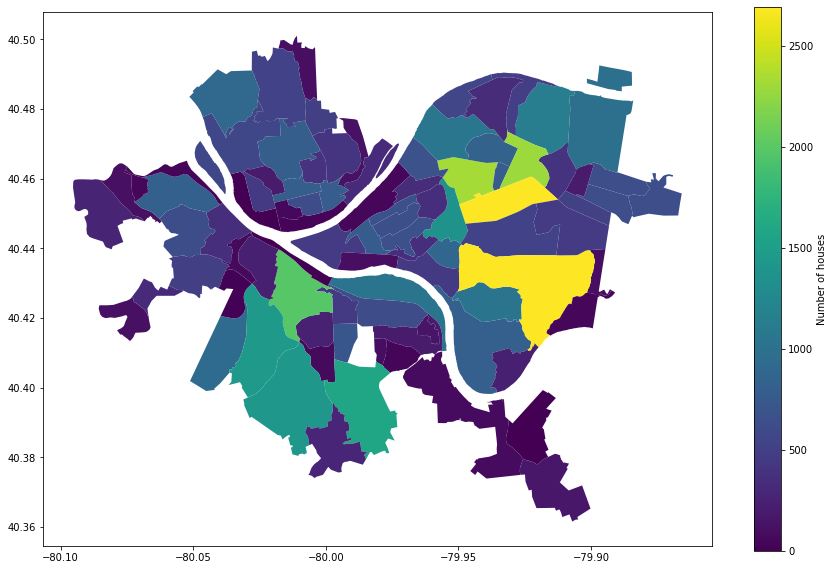

In [29]:
neighborhoods = gpd.read_file("Neighborhoods_.shp")
housing_map = neighborhoods.merge(contract_rent_pandas, how='left', left_on='hood', right_on='Neighborhood')

housing_map[['hood','homes under $1000','geometry']].head()
housing_map.plot(column = "homes under $1000" , legend = True , legend_kwds = {"label" : "Number of houses"} , figsize = (15 , 10))

Based on the data concerning rent prices, balancing both the average price and the total number of properties available, the best neighborhoods in Pittsburgh are East Liberty, Carrick, Beechview, Southside Flats, and Lincoln-Lemington-Belmar. They are all neighborhoods in the top 15 for total number of rent properties for under \\$1000, and most of the properties fall towards the middle of the price range, being neither at the upper or lower extreme of our price range. This is the ideal situation for most college graduates, because the higher number of rented properties will give them more options for where to live, and the more middle-of-the-road price range will fit more people's budget (but is not so low that it rules out a two bedroom place where one could get a roommate and further lower the individual cost). 

## The Best Neighborhood Based on Parking ##

In [30]:
#parking dataset
meters = pd.read_csv("https://data.wprdc.org/datastore/dump/9ed126cc-3c06-496e-bd08-b7b6b14b4109") #Read in the CSV file

Here we filter out any Parking meters that are not active, or have a longitude with value NaN or Latitude with value NaN. Then apply the query mask. 

In [31]:
query_mask = meters['status'] == "Active" #Check for active meters
latitude_mask= meters['latitude'].notna() #Check latitude column
longitude_mask = meters['longitude'].notna() #Check longitude column

locations_active = meters[query_mask & latitude_mask & longitude_mask] #Applying query masks

Create a list of all the points in the form **(latitude, longitude)**. Then create a Geopandas Data Frame from
1. The Filtered Parking Meters
2. The Coordinate System of Latitude and Longitude represented with code `EPSG:4326`
3. And the List of Geometry Objects Created

In [32]:
geometry = [Point(xy) for xy in zip(locations_active['longitude'], locations_active['latitude'])] #Utilizes Point function to create geometry objects for each point
geodata = gpd.GeoDataFrame(locations_active, crs='epsg:4326', geometry=geometry) #Create Geopandas DataFrame 

Now we plot the Geopandas DataFrame without the Shapefile, just to see what all of the data points look like.

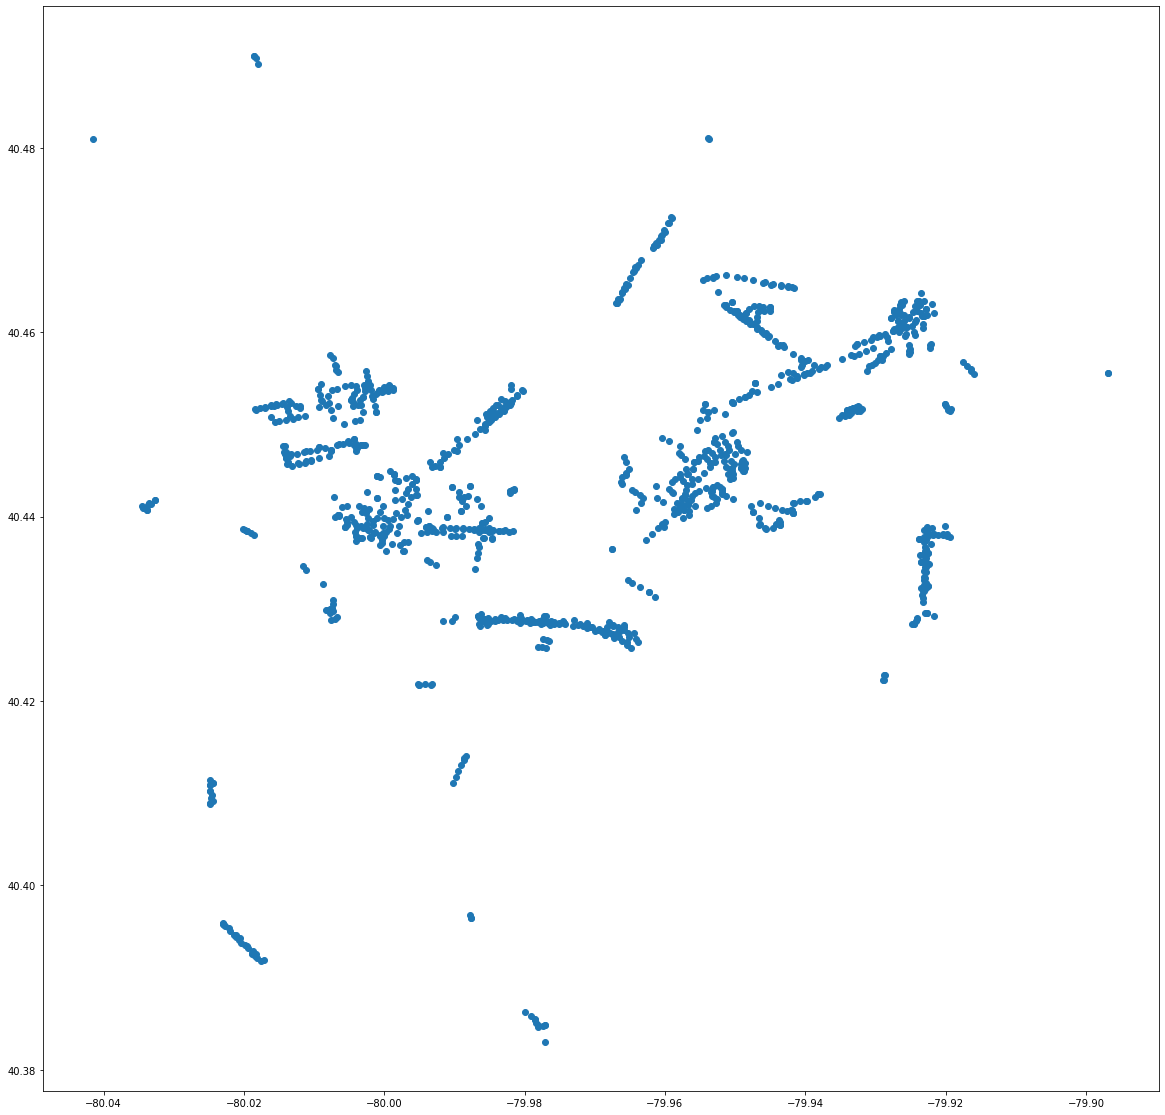

In [33]:
geodata.plot(figsize=(20,20)) #Change the size of the graph to be larger so points are visible
plt.show() #Display the graph

Next we read in the shapefile.

Below the shapefile is plotted to display the city of Pittsburgh and all of its neighborhoods. All of the parking meters will soon be plotted on top of this to determine the best places to park.

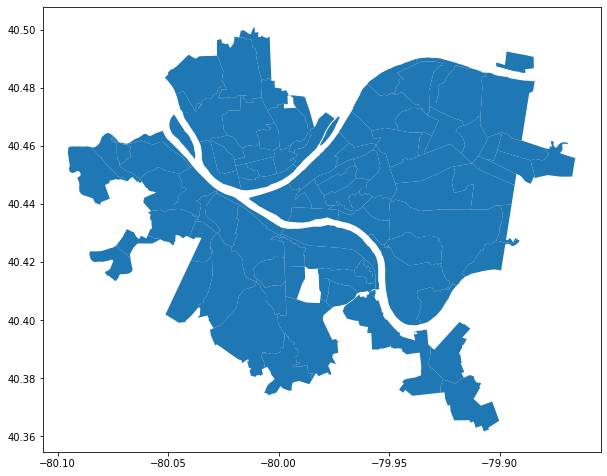

In [34]:
neighborhood = gpd.read_file("Neighborhoods_.shp") #Read in the shapefile
neighborhood = neighborhood.to_crs(crs='EPSG:4326') #Convert the x and y axis to be latitude and longitude
neighborhood.plot(figsize=(10,10)) #Graph the shapefile and change the figure size to be larger

Here we create subplots where we can graph the shapefile, and then the parking meter data on top. Then we are able to display a useful visual to help decide which neighborhood will most likely have free parking.

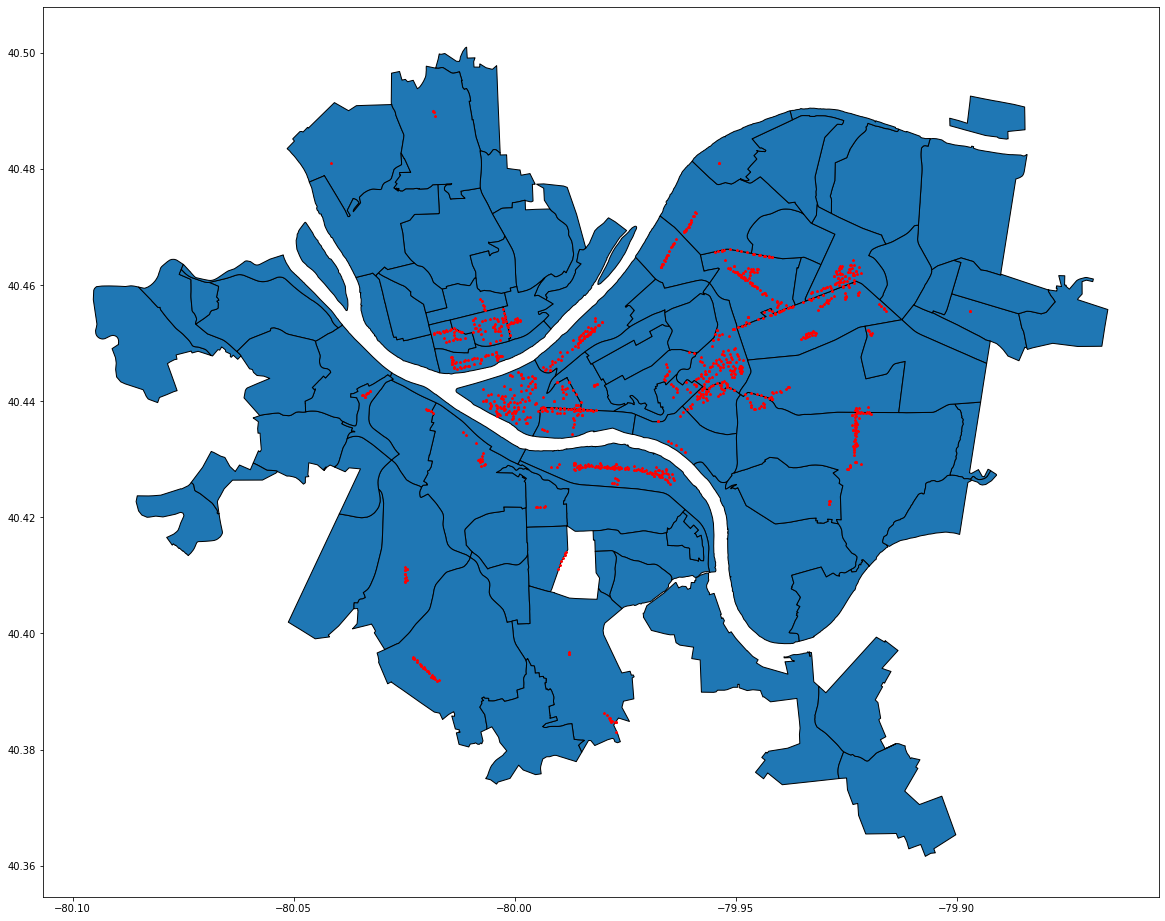

In [35]:
fig, ax = plt.subplots(figsize=(20,20)) #Create the subplots and change their size to be larger, making points easier to see

neighborhood.plot(ax=ax, edgecolor='k', alpha=1, linewidth=1) #Plot the shapefile
geodata.plot(ax=ax, color='red', marker="*", markersize=5) #Pot the parking meters

### What Can Be Seen Through This Visualization ###
Using this visualization, we are able to determine which neighborhood has the fewest number of parking meters, as it will have the fewest number of red dots within it. This data is very helpful as when we combine it with the rest of the metrics, we can determine a cost efficient neighborhood for someone to live who recently graduated college, and may not have a high budget.

## The best Neighborhood (Safety-Wise)

Create a df with the number of appearances of each neighborhood (number of total crimes in the dataset)

In [36]:
crimeByHood = crimes["INCIDENTNEIGHBORHOOD"]
numCrimes = crimeByHood.value_counts().rename_axis('Neighborhood').reset_index(name='Number of Crimes')

Create GeoPandas df

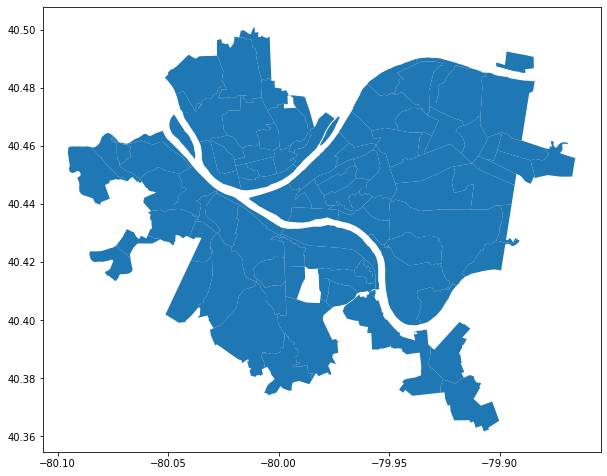

In [37]:
neighborhoods = gpd.read_file("Neighborhoods_.shp")
neighborhoods.plot(figsize = (10,10))
neighborhoods = neighborhoods[["hood", "geometry"]]

Search for neighborhoods that are not overlapping in either df

In [38]:
numCrimes.replace("Mt. Oliver Neighborhood", "Mt. Oliver", inplace = True)
for index, row in neighborhoods["hood"].iteritems(): 
    if row in numCrimes['Neighborhood'].tolist():
        pass
    else:
        print(row + " not in crime data set")
    #crime.replace("Mt. Oliver Neighborhood", "Mt. Oliver", inplace = True)

Add a row for percentage of crimes (based off of the highest crime neighborhood (Southside Flats))

In [39]:
#creating the percentages of the crimes compared to the neighborhood with the most crime (south side flats)
crimeMax = 15157
numCrimes["Percentage of Crimes"] = ""
percent = 0.0
for row in numCrimes.iterrows():
    percent = float(row[1][1])/crimeMax
    numCrimes['Percentage of Crimes'][row[0]] = percent
numCrimes.sort_values(by='Percentage of Crimes', ascending = True)
numCrimes.tail(20)
#these are the "best" 20 neighborhoods with the least number of crimes

<ipython-input-39-0780510b23b2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numCrimes['Percentage of Crimes'][row[0]] = percent


,Neighborhood,Number of Crimes,Percentage of Crimes
78,Fairywood,616,0.0406413
79,St. Clair,600,0.0395857
80,Glen Hazel,585,0.038596
81,Esplen,510,0.0336478
82,Oakwood,492,0.0324602
83,Hays,452,0.0298212
84,Regent Square,443,0.0292274
85,Summer Hill,421,0.0277759
86,Mount Oliver,412,0.0271822
87,Arlington Heights,408,0.0269183


Merge the two dfs

In [40]:
neighborhoods = neighborhoods.rename(columns={"hood": "Neighborhood"})
CrimeHoodMerged = neighborhoods.merge(numCrimes)

Plot the final graph of the merged data sets, highlighting the most crime in each neighborhood

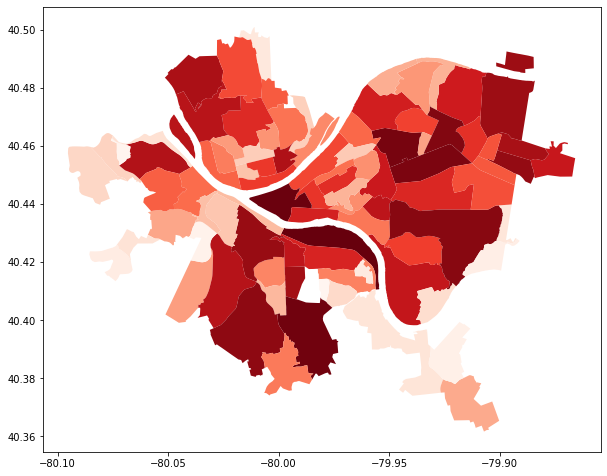

In [41]:
CrimeHoodMerged.plot(column = 'Percentage of Crimes', figsize = (10,10), cmap = "Reds", legend = False)

### What can we get out of this vizualization?
First off, the dark red are the neighborhoods with most crime, and the light red/pink is the neighborhoods with the least crime. We can notice some patterns here, such as: the outskirts of the city tend to have les crime, the darkest neighborhoods are the Southside Flats and the Central Business District, there are many "middle-ground" neighborhoods. From this display, we can see the darkest areas and which of them to avoid. However, the other middle ground neighborhoods are pretty much all similar because there are jsut so many. From this, we can pick the neighborhoods with the darkest coloring out, and only look towards the neighborhoods with lesser coloring (around 30 or 40 percent of crimes compared to Southside Flats). Anything that is less than 30-40% is fair game for us. The best neighborhood would have to be Mt. Oliver, however like we noticed, many of the neighborhoods have pretty small crime rates compared to the Southside Flats neighborhood.

## Combining our 3 Metrics into 1 ##

### The purpose of combining all 3 of our metrics into 1 is so that we can visually see the best neighborhood according to all of our metrics ##

In order to combine all 3 of our metrics into one we must first establish the base of our graph which will be the shapefile, and plot that onto the subplot. Each metric will be added onto the subplot in order to create layers, which will eventually create one graph displaying all of the information. 

Above we explained the process of getting the data, and showed the steps we took to analyze it. Below we will redo those steps just to ensure that we properly grab and handle the data.

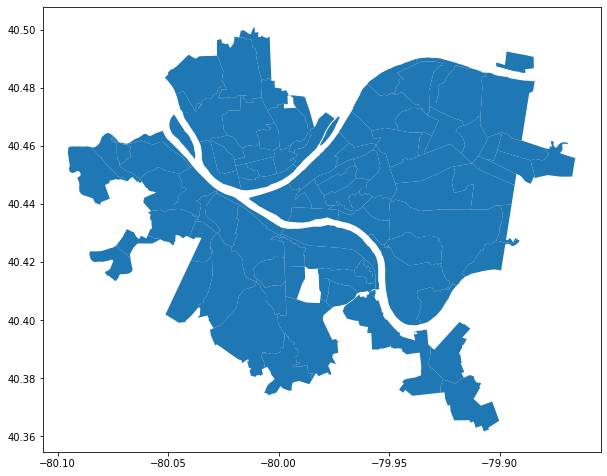

In [42]:
neighborhood = gpd.read_file("Neighborhoods_.shp") #Read in the shapefile
neighborhood = neighborhood.to_crs(crs='EPSG:4326') #Convert the x and y axis to be latitude and longitude
neighborhood.plot(figsize=(10,10)) #Graph the shapefile and change the figure size to be larger

### Parking Meter Metric ###

In [43]:
#parking dataset
meters = pd.read_csv("https://data.wprdc.org/datastore/dump/9ed126cc-3c06-496e-bd08-b7b6b14b4109") #Read in the CSV file

query_mask = meters['status'] == "Active" #Check for active meters
latitude_mask= meters['latitude'].notna() #Check latitude column
longitude_mask = meters['longitude'].notna() #Check longitude column

locations_active = meters[query_mask & latitude_mask & longitude_mask] #Applying query masks

geometry = [Point(xy) for xy in zip(locations_active['longitude'], locations_active['latitude'])] #Utilizes Point function to create geometry objects for each point
geodata = gpd.GeoDataFrame(locations_active, crs='epsg:4326', geometry=geometry) #Create Geopandas DataFrame 


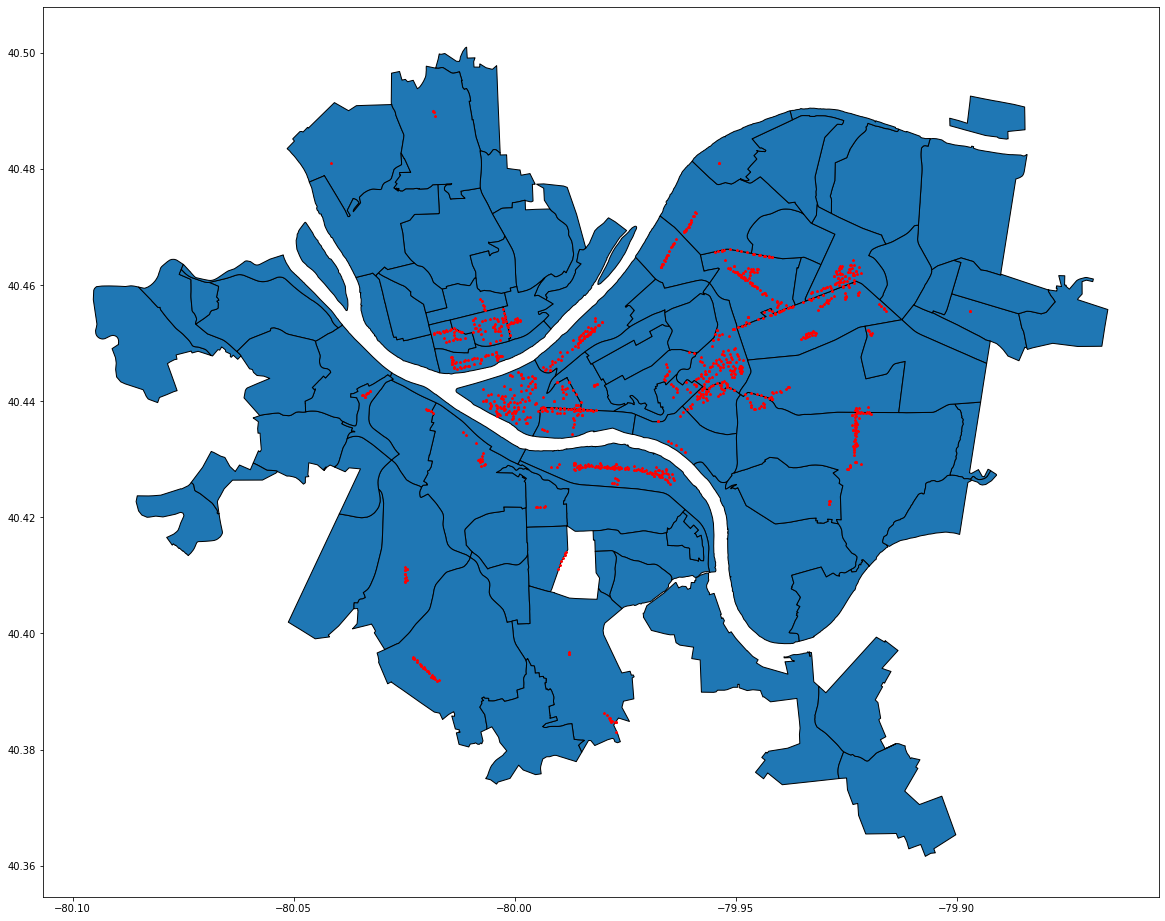

In [44]:
fig, ax = plt.subplots(figsize=(20,20)) #Create the subplots and change their size to be larger, making points easier to see

neighborhood.plot(ax=ax, edgecolor='k', alpha=1, linewidth=1) #Plot the shapefile
geodata.plot(ax=ax, color='red', marker="*", markersize=5) #Pot the parking meters


### Neighborhood Safety ###

In [45]:
# crime rates dataset
crimes = pd.read_csv("https://data.wprdc.org/datastore/dump/044f2016-1dfd-4ab0-bc1e-065da05fca2e")
crimes.head()

crimeByHood = crimes["INCIDENTNEIGHBORHOOD"]
numCrimes = crimeByHood.value_counts().rename_axis('Neighborhood').reset_index(name='Number of Crimes')

neighborhoods = gpd.read_file("Neighborhoods_.shp")
neighborhoods = neighborhoods[["hood", "geometry"]]

numCrimes.replace("Mt. Oliver Neighborhood", "Mt. Oliver", inplace = True)
for index, row in neighborhoods["hood"].iteritems(): 
    if row in numCrimes['Neighborhood'].tolist():
        pass
    else:
        print(row + " not in crime data set")
        
#creating the percentages of the crimes compared to the neighborhood with the most crime (south side flats)
crimeMax = 15157
numCrimes["Percentage of Crimes"] = ""
percent = 0.0
for row in numCrimes.iterrows():
    percent = float(row[1][1])/crimeMax
    numCrimes['Percentage of Crimes'][row[0]] = percent
numCrimes.sort_values(by='Percentage of Crimes', ascending = True)
numCrimes.tail(20)
#these are the "best" 20 neighborhoods with the least number of crimes

neighborhoods = neighborhoods.rename(columns={"hood": "Neighborhood"})
CrimeHoodMerged = neighborhoods.merge(numCrimes)


<ipython-input-45-5d8e9f28acef>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numCrimes['Percentage of Crimes'][row[0]] = percent


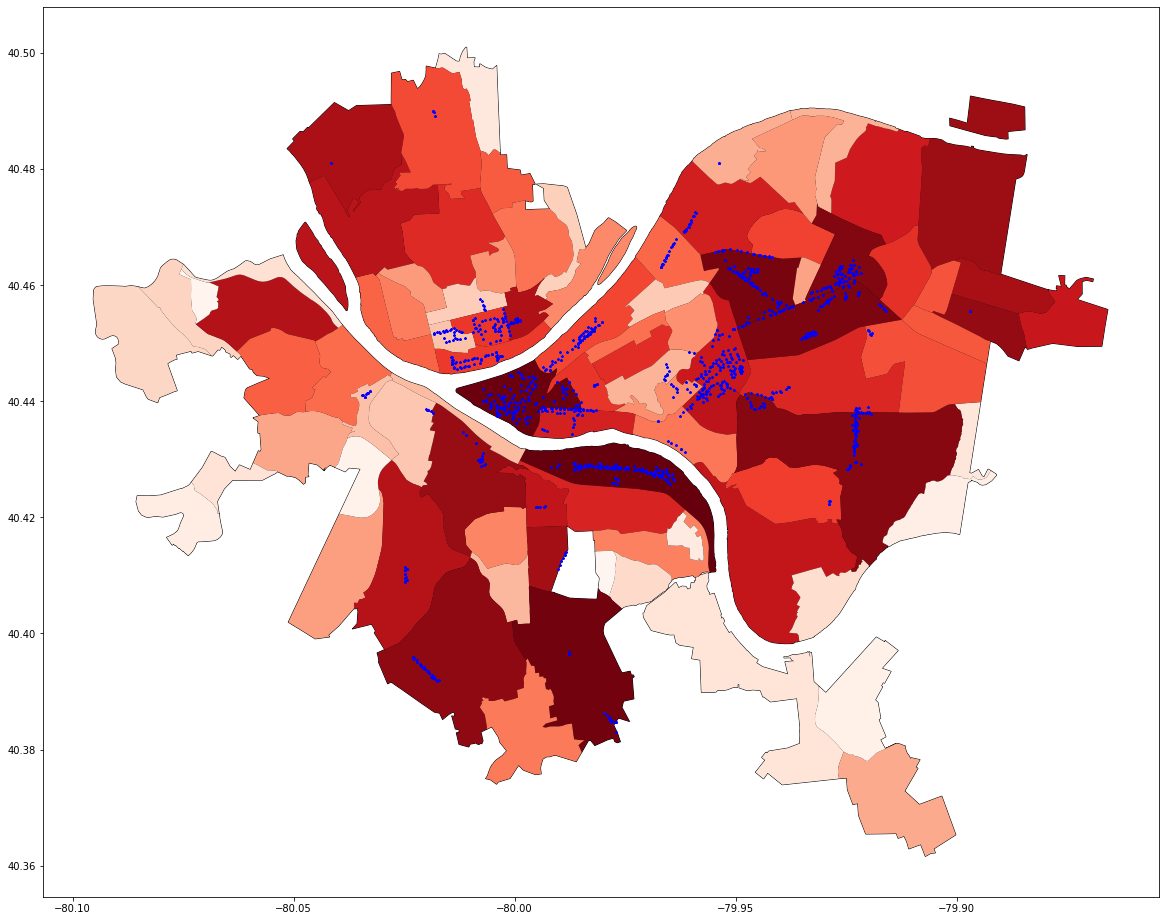

In [46]:
fig, ax = plt.subplots(figsize=(20,20)) #Create the subplots and change their size to be larger, making points easier to see
neighborhood.plot(ax=ax, edgecolor='k', alpha=1, linewidth=1) #Plot the shapefile
CrimeHoodMerged.plot(ax=ax, column = 'Percentage of Crimes', figsize = (10,10), cmap = "Reds", legend = False)
geodata.plot(ax=ax, color='blue', marker="*", markersize=5) #Pot the parking meters

plt.show()

### Housing Prices

In [21]:
#contract rent dataset
contract_rent_pandas = pd.read_csv("contract-rent.csv", 
                                       index_col="Neighborhood") 

#remove unnecessary columns
#comuns to remove
column_list = list(contract_rent_pandas)
columns_to_remove = ["Neighborhood" , "Id" , "Estimate; Total:" , "Margin of Error; Total:" , "Estimate; With cash rent:" , "Margin of Error; With cash rent:" , 
                    "Margin of Error; With cash rent: - Less than $100" , "Margin of Error; With cash rent: - $100 to $149" , "Margin of Error; With cash rent: - $150 to $199" , 
                    "Margin of Error; With cash rent: - $200 to $249" , "Margin of Error; With cash rent: - $250 to $299" , "Margin of Error; With cash rent: - $300 to $349" , 
                    "Margin of Error; With cash rent: - $350 to $399" , "Margin of Error; With cash rent: - $400 to $449" , "Margin of Error; With cash rent: - $450 to $499" , 
                    "Margin of Error; With cash rent: - $500 to $549" , "Margin of Error; With cash rent: - $550 to $599" , "Margin of Error; With cash rent: - $600 to $649" , 
                    "Margin of Error; With cash rent: - $650 to $699" , "Margin of Error; With cash rent: - $700 to $749" , "Margin of Error; With cash rent: - $750 to $799" , 
                    "Margin of Error; With cash rent: - $800 to $899" , "Margin of Error; With cash rent: - $900 to $999" , "Margin of Error; With cash rent: - $1,000 to $1,249" , 
                    "Margin of Error; With cash rent: - $1,250 to $1,499" , "Margin of Error; With cash rent: - $1,500 to $1,999" , "Margin of Error; With cash rent: - $2,000 to $2,499" , 
                    "Margin of Error; With cash rent: - $2,500 to $2,999" , "Margin of Error; With cash rent: - $3,000 to $3,499" , "Margin of Error; With cash rent: - $3,500 or more" , 
                    "Estimate; With cash rent: - $1,000 to $1,249" , "Estimate; With cash rent: - $1,250 to $1,499" , "Estimate; With cash rent: - $1,500 to $1,999" , 
                    "Estimate; With cash rent: - $2,000 to $2,499" , "Estimate; With cash rent: - $2,500 to $2,999" , "Estimate; With cash rent: - $3,000 to $3,499" , 
                    "Estimate; With cash rent: - $3,500 or more" , "Estimate; No cash rent" , "Margin of Error; No cash rent" , "homes under $1000"]

#remove and reorder them
homes_under_1000 = sorted( list(set(column_list) - set(columns_to_remove)))

#create a new column with the sum of the total amount of housing under $1000
contract_rent_pandas["homes under $1000"] = contract_rent_pandas[homes_under_1000].sum(axis = 1)

#merge housing cost dataframe with neighborhood shape file
housing_map = neighborhood.merge(contract_rent_pandas, how='left', left_on='hood', right_on='Neighborhood')




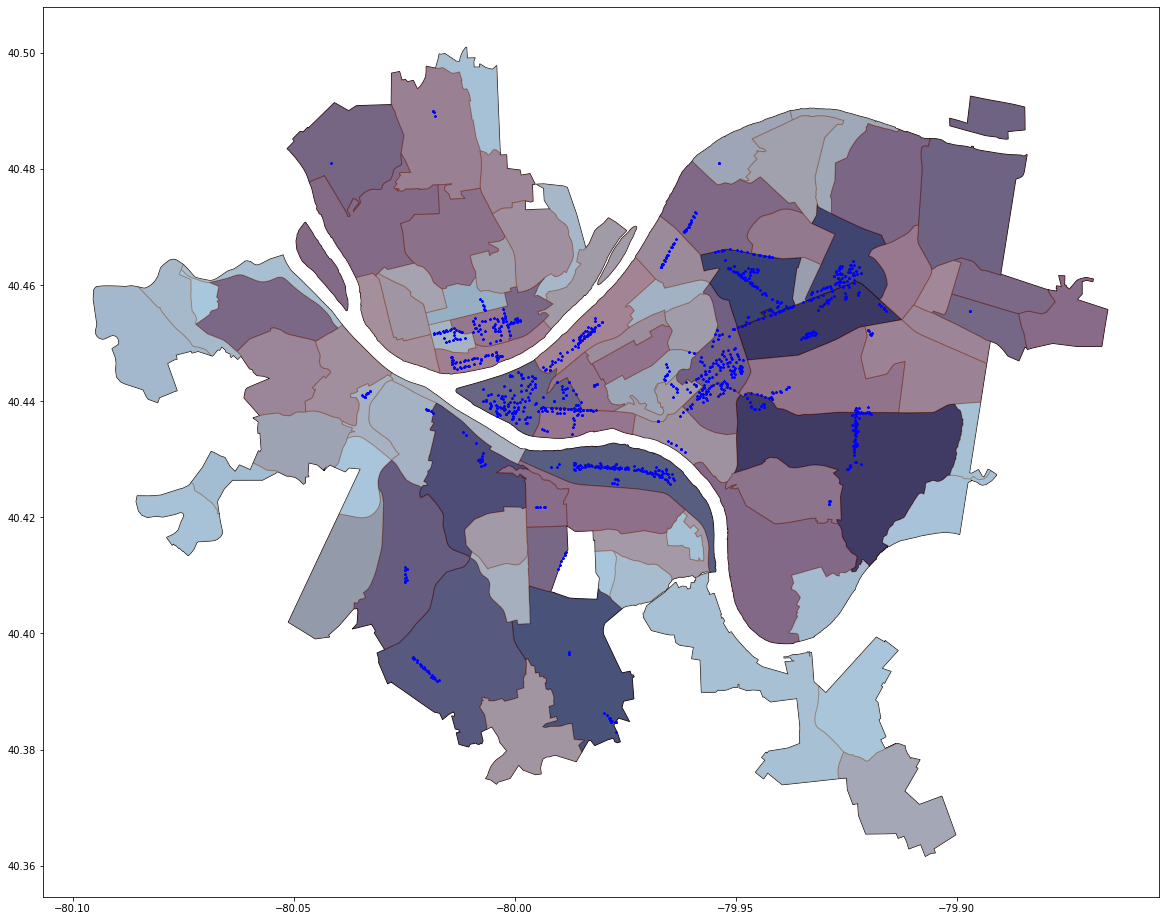

In [22]:
fig, ax = plt.subplots(figsize=(20,20)) #Create the subplots and change their size to be larger, making points easier to see
neighborhood.plot(ax=ax, edgecolor='k', alpha=1, linewidth=1) #Plot the shapefile
CrimeHoodMerged.plot(ax=ax, column = 'Percentage of Crimes', figsize = (10,10), cmap = "Reds", alpha = 0.5 , legend = False , zorder = 1) #Plotting crime rates
geodata.plot(ax=ax, color='blue', marker="*", markersize=5 , zorder = 3) #Pot the parking meters
housing_map.plot(ax=ax, column = "homes under $1000" , figsize = (10,10), cmap = "Blues" , alpha = 0.25 ,  legend = False , zorder = 2) #Plotting housing prices

plt.show()

# Conclusion


In merging all of our data, there is a very clear direct correlation between amount of rented housing, crime rates, and parking meters. While more rented housing is a good thing, more parking meters and crime is not, so we will have to balance those. There are also multiple neighborhoods around the edge of the city where there is not much data available on them (particularly concerning crime and parking meters, as the neighborhoods ended up being blue and blank on the map). While this looks good on paper (or screen), it is also possibly due to holes in the datasets, and also likely correlated with less people living there, as many of them also have few places for rent. Housing did also play a larger role in determining the best neighborhood, both because it is the biggest unavoidable expense of these, and because if you can't find somewhere to live there, it can't be the best neighborhood to live in. In making our decision for best neighborhood, we want to avoid the darkest ones on the map; as mentioned above, they tended to have a higher concentration of parking meters *and* higher crime rates, the combined expenses of which did outnumber the increased availability of housing (and, in the case of Squirrel Hill SOuth and Shadyside, the housing was on the expensive side of under \\$1000 and less ideal for someone looking to live cheap. 

Through that, we narrowed down the neighborhoods we were considering to the mid-tone neighborhoods on the map, and looked for ones that were a darker blue (they will lean more red than blue because the crime map is less transparent then the housing map because it needed to show through), as well as had minimal parking meters.

The best neighborhood in Pittsburgh for a broke recent college graduate is Beechview. For cheap housing, Beechview was in the top 5 for being reasonably priced with a higher amount of rented housing. Though there are some parking meters, they are clustered in one area of Beechview. It also has far less parking meters than East Liberty, which only slightly beat out Beechview in the housing category. In terms of safety, Beechview had around 28% of the crime that Southside Flats did, beating out Carrick, which was the other neighborhood ahead of Beechview in the housing metric. In our combined graph, Beechview was also a common middle ground for all three metrics. While there was still red (for crime), that was unavoidable if we were going to choose a neighborhood that had affordable housing (or housing in general). Of the neighborhoods with similar amounts of housing, especially peaking around the same price range, Beechview had the least amount of crime. In that subset of "mid-range" neighborhoods, Beechview also has less parking meters. It isn't the best neighborhood for any of our individual metrics, but in the combination of them it is the best result. 

## Reflections

## Safety
After looking at the data, I noticed how many neighborhoods there are with little to no crimes happening. Then again, these neighborhoods are almost all small (in size and population) as well as in the outskirts of the city, so it makes sense that there is little crime. I had been hoping to find that Shadyside was the best, as some of my favorite restaurants are there, and I like walking through there. Not suprisingly, the worst neighborhood (safety-wise) is the Southside Flats. I was also interested to see the crime surrounding oakland, and realizing that it is pretty minimal gives me even more security. The best neighborhood safety-wise is Mt. Oliver, however this is not a clear winner at all, and there are many, many other neighborhoods that are just as safe.

## Housing
My personal favorite neighborhoods are closer to the center of Pittsburgh-- I love Squirrel Hill and Shadyside. However, unsurprisingly, those are also more expensive neighborhoods. While the data driven determination of the best neighborhood was not entirely unexpected, it was slightly disappointing personally; I knew I probably couldn't afford Shadyside, but this just confirmed it. It does make sense to me that a neighborhood towards the outskirts of the city won; it reflects the I do think it would be worth considering transportation time and costs into determining where to live, and that would probably be the next metric I would consider if I were to add on to this project, because that is another high cost in an adult's day-to-day life. Given that Beechview won and is a neighborhood more on the outskirts of the city, I could see factoring in transportation to be a gamechanger. 

## Parking

After looking at the data, it is visible how some neighborhoods have significantly fewer parking meters than others. Some neighborhoods even have no parking meters at all. However, the neighborhoods without parking meters are most likely within industrial areas that would not have public parking or are in neighborhoods comprised solely of houses. It is visible within the graphic that areas such as cities have higher densities of parking meters, making those less viable options for living in if on a budget. Combining the data that I gathered with the rest of my group's data, I was able to see that Beechview had few to no parking meters, relatively reasonable pricing on homes, and are in low crime rate areas. While Beechview is not directly next to the city, which could be a negative to someone who has just graduated college from a city school, it is an excellent option for those directly out of school.